# Visible Watermark Information Classification Dataset

## RetinaNet w/ KerasCV Library

This notebook is a prototype for training a RetinaNet model using custom data.  More specifically, images that have been watermarked and annotated in Roboflow will be loaded and used in the pipeline.

In [23]:
import os
import math

import keras
import keras_cv
import tensorflow as tf
import keras_tuner as kt

# project utils
from lib.roboflow_yolov8_loader import RoboflowYOLOv8Loader
import lib.utils as utils

# Also possible to use jax or pytorch.
os.environ["KERAS_BACKEND"] = "tensorflow"

# Objects/Information we are trying to detect.
# numerical representation is based on list index.
CLASS_IDS = [
    "contact",  # contact information
    "identifier",  # image identifier
    "logo",  # a company logo
    "notice",  # copyright or other type of notice
]

DATA_DIR = "./visible-watermark-detection-VOC2007.v4i.yolov8"

BOUNDING_BOX_FORMAT = "xyxy"
BATCH_SIZE = 4

VALUE_RANGE = (0, 1)

## Load the visual watermark detection data

The splits below show roughly 85/15, but this is because I have also applied augmentations in Roboflow before exporting, increasing the size of the Training split.
The splits in the base dataset before augmentations still remains 70/20/10 (train/validation/10) before augmentation.

In [24]:
# construct custom dataset loader.
data_loader = RoboflowYOLOv8Loader(CLASS_IDS, DATA_DIR, batch_size=BATCH_SIZE)

# load dataset.
# split percentage is managed by Roboflow and exported.
train, val, test = data_loader.load_dataset()

# verify split percentage from Roboflow
utils.view_splits(train, val, test)

100%|██████████| 32/32 [00:00<00:00, 17730.22it/s]


         Dataset Splits          
   Split  Percentage
0  train       87.56
1    val        8.38
2   test        4.06


## Data Pre-Processing and Augmentation

Below is the same example of using augmentation for the dataset, shuffling and batching before fine tuning the model.

Augmentation is known to improve accuracy by increasing the size of the dataset dynamically by altering images from the
existing dataset.

In [25]:
augmenters = [
    keras_cv.layers.RandomSaturation(factor=0.1),
    keras_cv.layers.RandomBrightness(factor=0.1, value_range=VALUE_RANGE),
    keras_cv.layers.RandomContrast(factor=0.1, value_range=VALUE_RANGE),
    keras_cv.layers.RandomHue(factor=0.1, value_range=VALUE_RANGE),
    keras_cv.layers.JitteredResize(
        target_size=(640, 640),
        scale_factor=(0.9, 1.1),
        bounding_box_format=BOUNDING_BOX_FORMAT
    )
]   

def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn

augmenter_fn = create_augmenter_fn(augmenters)


resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format=BOUNDING_BOX_FORMAT, pad_to_aspect_ratio=True
)

def dict_to_tuple(inputs):
    return inputs["images"], keras_cv.bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=30
    )

TRAINING_SET_SIZE = len(train) # get total value before augmentation and batching
STEPS_PER_EPOCH = math.floor(TRAINING_SET_SIZE / BATCH_SIZE)
NUM_EPOCHS = 150

# load into correct format for the model
train_ds = ( train
                .shuffle(BATCH_SIZE * len(CLASS_IDS))
                .ragged_batch(BATCH_SIZE, drop_remainder=True)
                .map(augmenter_fn, num_parallel_calls=tf.data.AUTOTUNE)
                .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
                .prefetch(tf.data.AUTOTUNE)
           )

val_ds =   ( val
                .ragged_batch(BATCH_SIZE, drop_remainder=True)
                .map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
                .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
                .prefetch(tf.data.AUTOTUNE)
           )

test_ds =  ( test
                .ragged_batch(BATCH_SIZE, drop_remainder=True)
                .map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
                .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
                .prefetch(tf.data.AUTOTUNE)
           )

TRAINING DATA


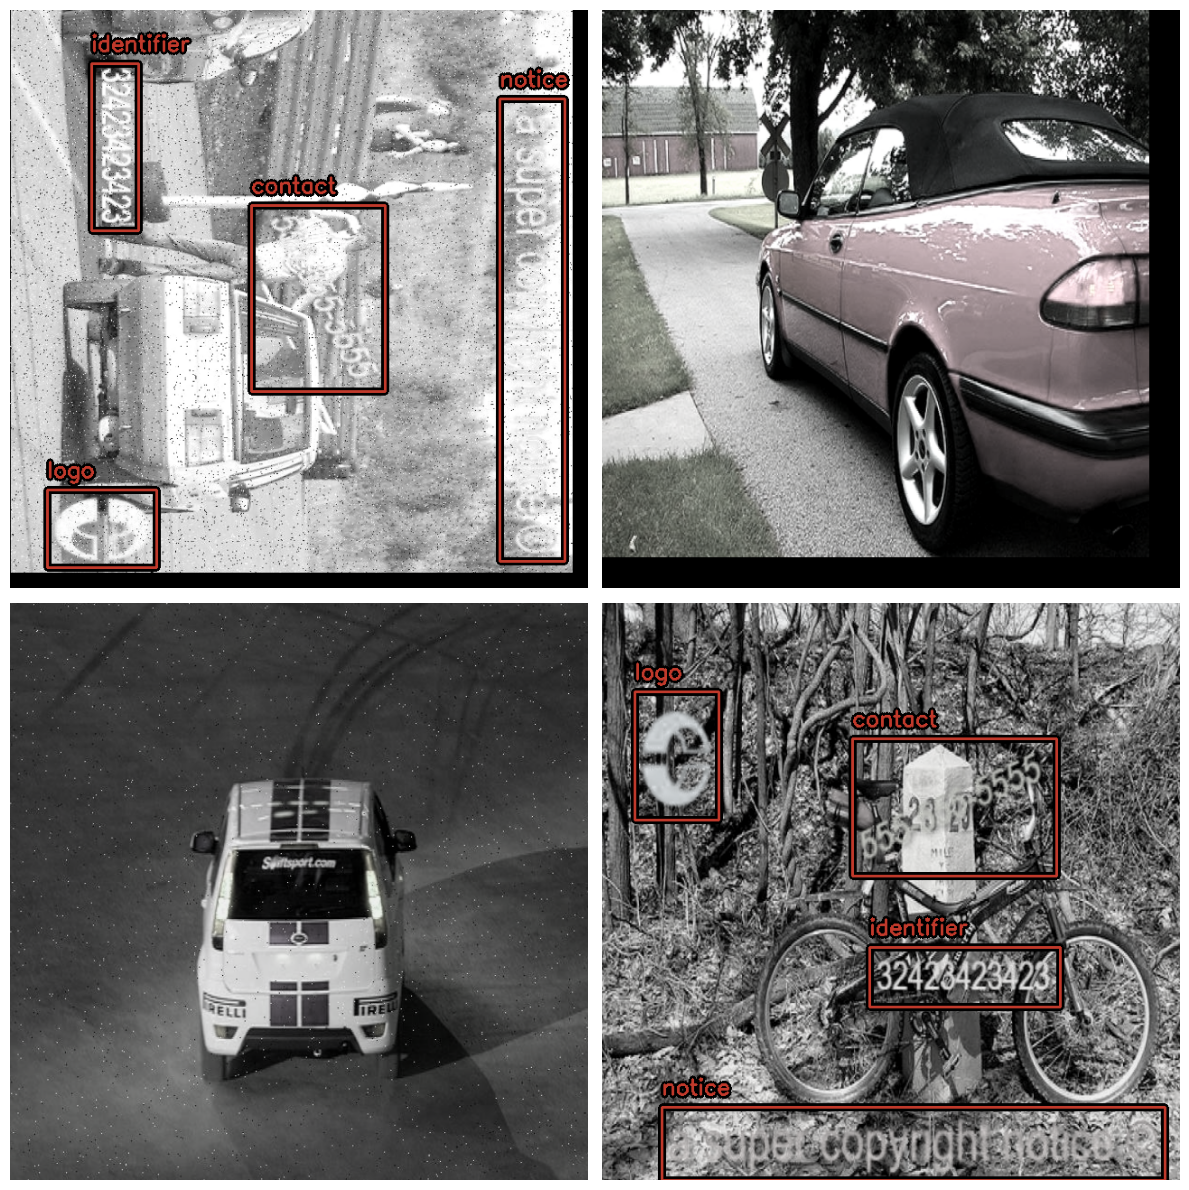

In [26]:
# visualize the training split.
print("TRAINING DATA")
utils.visualize_dataset(
    train_ds.skip(4), # first 4 don't have annotations
    data_loader.class_mapping,
    bounding_box_format=BOUNDING_BOX_FORMAT, 
    rows=2, cols=2, 
)

VALIDATION DATA


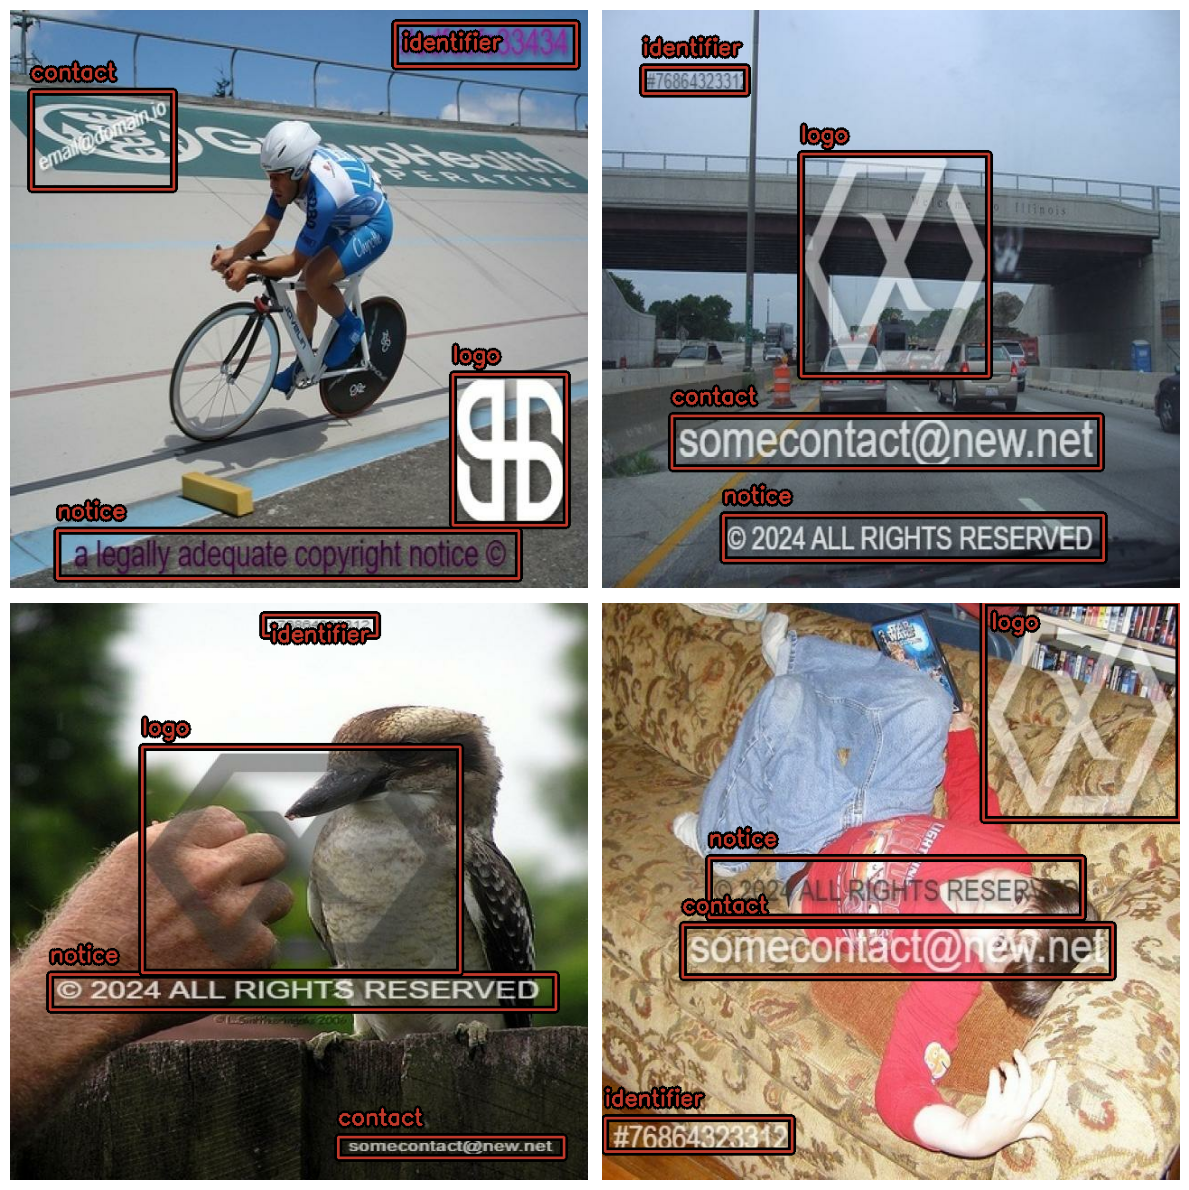

In [27]:
print("VALIDATION DATA")
utils.visualize_dataset(
    val_ds.skip(2), # first 2 don't have annotations
    data_loader.class_mapping,
    bounding_box_format=BOUNDING_BOX_FORMAT,
    rows=2,
    cols=2,
)

In [28]:
model = keras_cv.models.object_detection.RetinaNet.from_preset(
    "yolo_v8_m_backbone_coco",
    num_classes=len(CLASS_IDS),
    bounding_box_format=BOUNDING_BOX_FORMAT,
    load_weights=True,
)

initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate,
    decay_steps=math.floor(STEPS_PER_EPOCH * NUM_EPOCHS),
    alpha=0.0,
)

optimizer = keras.optimizers.AdamW(learning_rate=lr_schedule, global_clipnorm = 9.0)

model.compile(
    classification_loss="focal", # loss functions used from the RetinaNet Paper.
    box_loss="smoothl1",
    optimizer=optimizer,
)

## Train the RetinaNet model using custom watermark dataset

The code below leverages functions available in the Keras computer vision library to help visualize model predictions so that they can be evaluated visually after each epoch.  This helps to understand the progress and give a visual representation of the mapping between detections and COCO metrics used when training the model.

In [29]:
# Train the RetinaNet model using custom watermark image dataset.
model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=STEPS_PER_EPOCH, # matches decay_steps for regularization
    epochs=NUM_EPOCHS,  # early stopping callback may mean this is never reached.
    callbacks=[
        # Tuning the model based on metrics from this callback has been very inconsistent. 
        # This is left here for demonstration purposes, but should be replaced.
        # Github issues:
        #   - https://github.com/keras-team/keras-cv/issues/2402
        #   - https://github.com/keras-team/keras-cv/issues/2442
        keras_cv.callbacks.PyCOCOCallback(  # COCO metrics (AP/AR @ IOU)
            val_ds,
            bounding_box_format=BOUNDING_BOX_FORMAT,
        ),
        keras.callbacks.TensorBoard(  # training progress visualization
            log_dir="training_logs"
        ),
        keras.callbacks.ModelCheckpoint(
            filepath="./model/best_model.keras",
            monitor="val_loss",     # using combination of class/box loss since PyCOCOCallback unreliable.
            save_best_only=True,  # Only keep the best model
            verbose=1,
        ),
        keras.callbacks.EarlyStopping(
            patience=7,
            monitor="val_loss", # using combination of class/box loss since PyCOCOCallback unreliable.
            verbose=1,
            restore_best_weights=True,  # Restore weights of the best epoch
        ),
    ],
    # verbose=0,  # suppress epoch output since monitoring in TensorBoard.
)

Epoch 1/150


/home/gb/vwic/keras_cv/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'images': 'images'}
Received: inputs=Tensor(shape=(4, 640, 640, 3))
  warnings.warn(msg)
/home/gb/vwic/keras_cv/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_412']
Received: inputs=Tensor(shape=(4, 640, 640, 3))
  warnings.warn(msg)
I0000 00:00:1742659308.621414   72417 service.cc:148] XLA service 0x563f764aef00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742659308.624783   72417 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2025-03-22 12:01:50.667312: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPROD

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - box_loss: 0.5325 - classification_loss: 0.6320 - loss: 1.1645

2025-03-22 12:03:07.995842: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[4,256,80,80]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,256,80,80]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-22 12:03:08.248320: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[4,256,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,256,40,40]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAct

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 422ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.048
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.083
 Average Recall     (AR) @[ IoU=0.50:0.9

## Final visualization on test data

After the model has been fine-tuned with the custom training and validation data, it is essential to evaluate the models ability to generalize to unseen data.  To do this we need to use the test set, since it was not used during the training process. (Simple hold off.)

This method may be evolved as-needed throughout the project to improve the accuracy of the detector.

/home/gb/vwic/keras_cv/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'images': 'images'}
Received: inputs=Tensor(shape=(4, 640, 640, 3))
  warnings.warn(msg)
/home/gb/vwic/keras_cv/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_412']
Received: inputs=Tensor(shape=(4, 640, 640, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


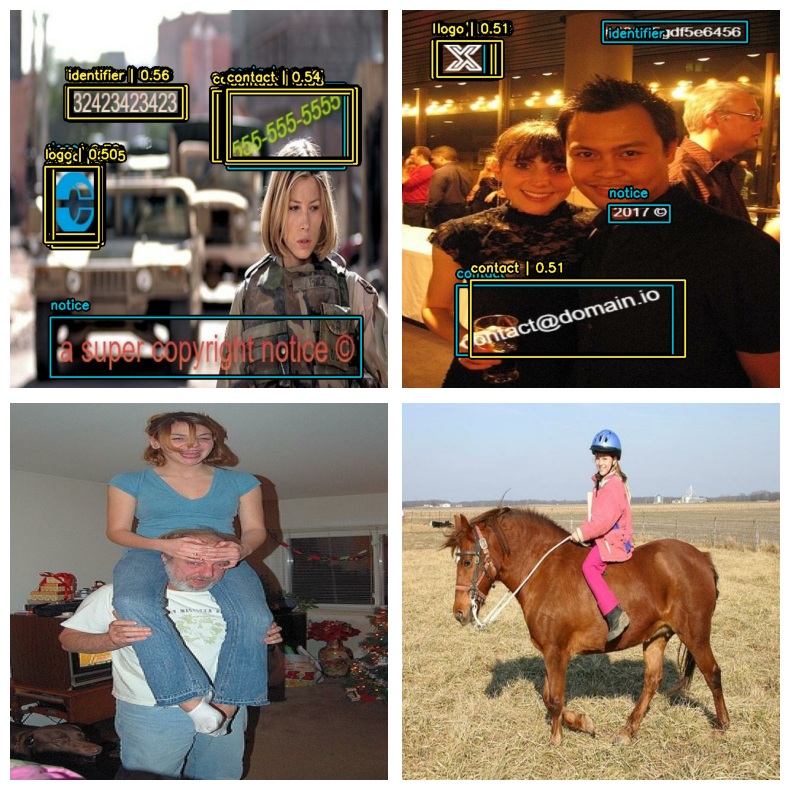

evaluating...:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


evaluating...:  12%|█▎        | 1/8 [00:00<00:05,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


evaluating...:  25%|██▌       | 2/8 [00:01<00:03,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


evaluating...:  38%|███▊      | 3/8 [00:01<00:02,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


evaluating...:  50%|█████     | 4/8 [00:02<00:02,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


evaluating...:  62%|██████▎   | 5/8 [00:02<00:01,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


evaluating...:  75%|███████▌  | 6/8 [00:03<00:01,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


evaluating...:  88%|████████▊ | 7/8 [00:03<00:00,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


evaluating...: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


         COCO Metrics            
                         Metric     Value
0                           MaP  0.117252
1                  MaP@[IoU=50]  0.174377
2                  MaP@[IoU=75]  0.155236
3              MaP@[area=small]  0.000000
4             MaP@[area=medium]  0.135625
5              MaP@[area=large]  0.103103
6     Recall@[max_detections=1]  0.299138
7    Recall@[max_detections=10]  0.350000
8   Recall@[max_detections=100]  0.360345
9           Recall@[area=small]  0.000000
10         Recall@[area=medium]  0.364098
11          Recall@[area=large]  0.303333


In [30]:
model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format=BOUNDING_BOX_FORMAT,
    from_logits=True,
    iou_threshold=0.2,
    confidence_threshold=0.5,
)

utils.visualize_detections(
    model,
    dataset=test_ds,
    bounding_box_format=BOUNDING_BOX_FORMAT,
    class_mapping=data_loader.class_mapping,
)

utils.evaluate_coco_metrics(model, test_ds, BOUNDING_BOX_FORMAT)


# References

[1] Team, Keras. “Keras Documentation: Efficient Object Detection with YOLOV8 and KerasCV.” Keras.io, keras.io/examples/vision/yolov8/.

[2] K. Team, “Keras documentation: Keras API reference,” keras.io. https://keras.io/api/

[3] Izaguirre, E. (2023). Object Detection using RetinaNet and KerasCV - TDS Archive - Medium. [online] Medium. Available at: https://medium.com/data-science/object-detection-using-retinanet-and-kerascv-b07940327b6c [Accessed 25 Feb. 2025].

[4] Lin, T.-Y., Goyal, P., Girshick, R., He, K. and Dollar, P. (2018). Focal loss for dense object detection. IEEE Transactions on Pattern Analysis and Machine Intelligence, pp.1–1. doi:https://doi.org/10.1109/tpami.2018.2858826.
‌